# Improving our model

Bertrand Thia (bt2513)

In this notebook, we are going to use the previous knowledge to build an improved model.

---

In [134]:
# importing the librairies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import compute_class_weight

np.random.seed(0)

# Loading the data and data preprocessing

In [2]:
train_labels = pd.read_csv('../train.csv')

### Splitting into training set and validation set 

In [3]:
train_set, valid_set = train_test_split(train_labels, test_size= 0.2, random_state= 0, 
                                        stratify= train_labels['label'])

In [4]:
print('Train size: %d \t Validation size: %d' %(len(train_set), len(valid_set)))

Train size: 901 	 Validation size: 226


In [5]:
train_set['label'].value_counts()

normal       280
bacterial    280
viral        280
covid         61
Name: label, dtype: int64

### Standardization

Let's load and standardized our data. To address the overfitting issue, we are going to use data augmentation here. This will allow us to increase the size of our dataset, but also make the classification more challenging. Since our dataset is small, we are just going to use some small image rotation:

In [6]:
train_datagen = ImageDataGenerator(samplewise_center=True,
                                  samplewise_std_normalization=True, 
                                  rotation_range= 20)

val_datagen = ImageDataGenerator(samplewise_center=True,
                                 samplewise_std_normalization=True)

Let's use the same parameters as previously:

In [7]:
BATCH_SIZE = 32
W = 312
H = 251

X_train = train_datagen.flow_from_dataframe(dataframe= train_set,
                                            directory= '../train/',
                                            x_col = 'filename',
                                            y_col = 'label', 
                                            target_size = (W, H),
                                            batch_size= BATCH_SIZE, 
                                            color_mode= 'grayscale',
                                            seed= 0)

X_val = val_datagen.flow_from_dataframe(dataframe= valid_set,
                                        directory= '../train/',
                                        x_col = 'filename',
                                        y_col = 'label', 
                                        target_size = (W, H),
                                        batch_size= BATCH_SIZE, 
                                        color_mode= 'grayscale',
                                        seed= 0)

Found 901 validated image filenames belonging to 4 classes.
Found 226 validated image filenames belonging to 4 classes.


# Model building

We are first going to keep the same structure for our model since it worked quite well and see if we can avoid overfitting:

In [40]:
bas_model = Sequential()
bas_model.add(Conv2D(16, (3, 3), input_shape= (W, H, 1), activation= 'relu'))
bas_model.add(MaxPooling2D(pool_size= (2, 2)))

bas_model.add(Conv2D(32, (3, 3), activation= 'relu'))
bas_model.add(Conv2D(32, (3, 3), activation= 'relu'))
bas_model.add(BatchNormalization())
bas_model.add(MaxPooling2D(pool_size= (2, 2)))
bas_model.add(Dropout(0.25)) 

bas_model.add(Flatten())

bas_model.add(Dense(units= 128, activation= 'relu')) 
bas_model.add(Dropout(0.5)) 

bas_model.add(Dense(units= 64, activation= 'relu')) 
bas_model.add(Dropout(0.3)) 

bas_model.add(Dense(units= 4, activation= 'softmax'))

In [41]:
bas_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 310, 249, 16)      160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 155, 124, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 153, 122, 32)      4640      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 151, 120, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 151, 120, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 75, 60, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 75, 60, 32)       

In [42]:
bas_model.compile(loss= 'categorical_crossentropy',
                 optimizer= Adam(lr= 1e-4), 
                 metrics = ['accuracy'])

### Training 

In [11]:
epochs= 70
#es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, restore_best_weights= True, patience= 3)
filepath="weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor= 'val_accuracy', verbose= 1, period= 1)

Since our dataset is imbalanced, we are going to use class weigthing to address the issue:

In [12]:
train_set2 = train_set.copy()
train_set2['label'] = train_set2['label'].map({'bacterial': 0, 'covid': 1, 'normal': 2, 'viral': 3})
class_weight = compute_class_weight('balanced', [0, 1, 2, 3], train_set2['label'])
class_weight

array([0.80446429, 3.69262295, 0.80446429, 0.80446429])

In [13]:
hist = bas_model.fit_generator(X_train, 
                                steps_per_epoch= len(train_set) // BATCH_SIZE, 
                                epochs= epochs, 
                                verbose= 1, 
                                validation_data = X_val, 
                                validation_steps= len(valid_set) // BATCH_SIZE,
                                class_weight= class_weight,
                                callbacks= [checkpoint])

Epoch 1/70
28/28 [==============================] - 35s 1s/step - loss: 1.7419 - accuracy: 0.3867 - val_loss: 1.3244 - val_accuracy: 0.5045

Epoch 00001: saving model to weights-improvement-01-0.50.hdf5
Epoch 2/70
28/28 [==============================] - 38s 1s/step - loss: 1.1699 - accuracy: 0.4925 - val_loss: 1.1872 - val_accuracy: 0.4794

Epoch 00002: saving model to weights-improvement-02-0.48.hdf5
Epoch 3/70
28/28 [==============================] - 38s 1s/step - loss: 1.1496 - accuracy: 0.5257 - val_loss: 1.2527 - val_accuracy: 0.6649

Epoch 00003: saving model to weights-improvement-03-0.66.hdf5
Epoch 4/70
28/28 [==============================] - 36s 1s/step - loss: 1.0313 - accuracy: 0.5796 - val_loss: 1.1978 - val_accuracy: 0.7423

Epoch 00004: saving model to weights-improvement-04-0.74.hdf5
Epoch 5/70
28/28 [==============================] - 35s 1s/step - loss: 0.9903 - accuracy: 0.5892 - val_loss: 1.1931 - val_accuracy: 0.7371

Epoch 00005: saving model to weights-improvemen

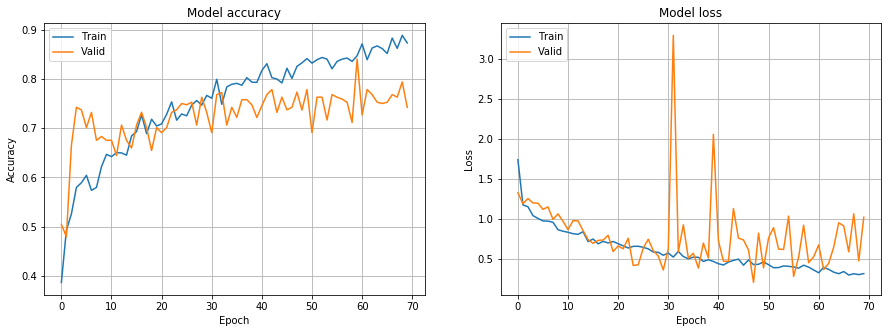

In [14]:
# Plotting the training curves

fig, axs = plt.subplots(1, 2, figsize= (15, 5))

# Plot training & validation accuracy values
axs[0].plot(hist.history['accuracy'])
axs[0].plot(hist.history['val_accuracy'])
axs[0].set_title('Model accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Valid'], loc='upper left')
axs[0].grid()

# Plot training & validation loss values
axs[1].plot(hist.history['loss'])
axs[1].plot(hist.history['val_loss'])
axs[1].set_title('Model loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(['Train', 'Valid'], loc='upper left')
plt.show()

### Evaluating our best model

In [118]:
# Loading the best weights
#bas_model.load_weights("weights-improvement-43-0.78.hdf5")
bas_model.load_weights("weights-improvement-60-0.84.hdf5")

In [119]:
evaluation = bas_model.evaluate_generator(X_val)
print('Accuracy on the validation set: {:.3f}'.format(evaluation[1]))

Accuracy on the validation set: 0.761


In [136]:
# Loading the validation set without shuffling the data to compare manually 
X_val2 = val_datagen.flow_from_dataframe(dataframe= valid_set,
                                        directory= '../train/',
                                        x_col = 'filename',
                                        y_col = 'label', 
                                        target_size = (W, H),
                                        batch_size= BATCH_SIZE, 
                                        color_mode= 'grayscale',
                                        shuffle= False)

Found 226 validated image filenames belonging to 4 classes.


In [137]:
pred = bas_model.predict_generator(X_val2)
y_pred = pred.argmax(axis=1)
y_pred[:10]

array([1, 3, 0, 3, 2, 2, 3, 0, 0, 2])

In [138]:
X_val.class_indices

{'bacterial': 0, 'covid': 1, 'normal': 2, 'viral': 3}

In [139]:
y_val = valid_set['label'].map(X_val.class_indices).values

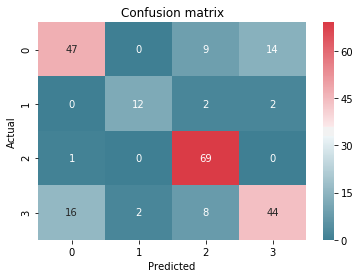

In [140]:
data = {'y_val': y_val, 'y_pred': y_pred}
df = pd.DataFrame(data)
confusion_matrix = pd.crosstab(df['y_val'], df['y_pred'], 
                               rownames=['Actual'], 
                               colnames=['Predicted'])

cmap = sns.diverging_palette(220, 10, as_cmap= True)
sns.heatmap(confusion_matrix, annot=True, cmap= cmap)
plt.title('Confusion matrix')
plt.show()

In [141]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.73      0.67      0.70        70
           1       0.86      0.75      0.80        16
           2       0.78      0.99      0.87        70
           3       0.73      0.63      0.68        70

    accuracy                           0.76       226
   macro avg       0.78      0.76      0.76       226
weighted avg       0.76      0.76      0.75       226



# Predicting on the test set

In this section, we are going to predict the labels of the test set using our improved model and save them.

### Loading the test set

In [126]:
test_df = pd.read_csv('../test.csv')

In [127]:
test_df.head()

,id,filename
0,0,test/img-0.jpeg
1,1,test/img-1.jpeg
2,2,test/img-2.jpeg
3,3,test/img-3.jpeg
4,4,test/img-4.jpeg


In [128]:
test_datagen = ImageDataGenerator(samplewise_center=True,
                                 samplewise_std_normalization=True)
X_test = test_datagen.flow_from_directory('../test',
                                           classes = ['test'], 
                                           batch_size= BATCH_SIZE, 
                                           target_size = (W, H),
                                           color_mode= 'grayscale',
                                           shuffle= False)

Found 484 images belonging to 1 classes.


In [129]:
pred = bas_model.predict_generator(X_test)
y_pred = pred.argmax(axis=1)
y_pred[:10]

array([0, 2, 0, 3, 2, 2, 3, 0, 1, 2])

### Formatting the output like the submission example

In [130]:
submission = pd.read_csv('../submission.csv')
submission.head()

,Id,label
0,0,bacterial
1,1,viral
2,2,normal
3,3,normal
4,4,bacterial


In [131]:
data = {'Id': test_df['id'], 'label': y_pred}
output = pd.DataFrame(data)
output['label'] = output['label'].map({0:'bacterial', 1: 'covid', 2: 'normal', 3: 'viral'})
output

,Id,label
0,0,bacterial
1,1,normal
2,2,bacterial
3,3,viral
4,4,normal
...,...,...
479,479,viral
480,480,bacterial
481,481,viral
482,482,viral


In [132]:
# saving the output
output.to_csv('output_best.csv', index= False)

---

# Appendix

In [29]:
# Computing the accuracy manually to check 
(df['y_val'] == df['y_pred']).sum() / len(df)

0.7566371681415929